# Installing the environment

## Importing modules and libraries


In [ ]:

from IPython.display import HTML # to display videos
import base64 # to encode videos as base64
from base64 import b64encode # to encode videos as base64
import os # to interact with the operating system
import subprocess # to run commands
import time # to measure execution time
import csv # to save comments
import uuid # to generate unique ids
import cv2 # to split videos
from PIL import Image # to display videos
import pandas as pd # to display comments
import numpy as np # to use Numerical Python
from io import BytesIO #for a binary stream of data in memory


## GitHub

In [ ]:
def download(directory, filename):
    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/RAG-Driven-Generative-AI/main/'

    # Complete URL for the file
    file_url = f"{base_url}{directory}/{filename}"

    # Use curl to download the file, including an Authorization header for the private token
    try:
        # Prepare the curl command
        curl_command = f'curl -o {filename} {file_url}'

        # Execute the curl command
        subprocess.run(curl_command, check=True, shell=True)
        print(f"Downloaded '{filename}' successfully.")
    except subprocess.CalledProcessError:
        print(f"Failed to download '{filename}'. Check the URL, your internet connection and the file path")

## OpenAI

In [ ]:
#You can retrieve your API key from a file(1)
# or enter it manually(2)
#Comment this cell if you want to enter your key manually.

#(1)Retrieve the API Key from a file
#Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
from google.colab import drive
drive.mount('/content/drive')
f = open("drive/MyDrive/api_key.txt", "r")
API_KEY=f.readline()
f.close()

Mounted at /content/drive


In [ ]:
try:
  import openai
except:
  !pip install openai==1.45.0
  import openai

In [ ]:
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

## Pinecone

In [ ]:
!pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.4/421.4 kB 23.4 MB/s eta 0:00:00


In [ ]:
import pinecone

In [ ]:
f = open("drive/MyDrive/pinecone.txt", "r")
PINECONE_API_KEY=f.readline()
f.close()
os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

# The pinecone index

In [ ]:
import os
from pinecone import Pinecone, ServerlessSpec

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.environ.get('PINECONE_API_KEY') or 'PINECONE_API_KEY'

from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key=PINECONE_API_KEY)

In [ ]:
from pinecone import ServerlessSpec

index_name = 'videos-sports-us'
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [ ]:
# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 823}},
 'total_vector_count': 823,
 'vector_type': 'dense'}

# Defining the RAG functions

## Embedding

In [ ]:
embedding_model = "text-embedding-3-small"

client = openai.OpenAI()

def get_embedding(text, model=embedding_model):
    # Ensure the text is a string and replace newline characters with spaces
    text = str(text).replace("\n", " ")
    response = client.embeddings.create(input=[text], model=model)
    embedding = response.data[0].embedding
    return embedding

## Query pinecone

In [ ]:
def query_pinecone(query_text, k):
  query_embedding = get_embedding(query_text, model=embedding_model)
  query_results = index.query(vector=query_embedding, top_k=k, include_metadata=True)
  return query_results

In [ ]:
def collect_query_results(query_results):
  results = []
  for _match in query_results['matches']:
    result = {
        "ID": _match['id'],
        "Score": _match['score']
    }

    if 'metadata' in _match:
      metadata = _match['metadata']
      result['Text'] = metadata.get('text', "No text metadata available.")
      result['Frame Number'] = metadata.get('frame_number', "No frame number available.")
      result['File Name'] = metadata.get('file_name', "No file name available.")
    else:
      result['Text'] = "No metadata available."
      result['Frame Number'] = "No metadata available."
      result['File Name'] = "No metadata available."

    results.append(result)

  return results

## Augmented Retrieval Generation

In [ ]:
from openai import OpenAI

def get_openai_response(prompt):
    # Initialize the client
    client = OpenAI()

    # Create a completion request to OpenAI
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {
                "role": "system",
                "content": "You will be provided with comments of an image frame taken from a video. Analyze the text and 1. Point out the cognitive dissonances 2. Rewrite the comment in a logical engaging style. 3. Provide a label for this image such as Label: basketball, football, soccer or other label."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        temperature=0,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    # Return the content of the response
    return response.choices[0].message.content

# Display video


In [ ]:
# Open the file in binary mode
def display_video(file_name):
  with open(file_name, 'rb') as file:
      video_data = file.read()

  # Encode the video file as base64
  video_url = b64encode(video_data).decode()

  # Create an HTML string with the embeddZed video
  html = f'''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{video_url}" type="video/mp4">
  Your browser does not support the video tag.
  </video>
  '''
  # Display the video
  HTML(html)
  # Return the HTML object
  return HTML(html)

In [ ]:
def display_video_frame(file_name, frame_number, size):
    # Open the video file
    cap = cv2.VideoCapture(file_name)

    # Move to the frame_number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    success, frame = cap.read()
    if not success:
        return "Failed to grab frame"

    # Convert the color from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to PIL image and resize
    img = Image.fromarray(frame)
    mg = img.resize(size, Image.LANCZOS)  # Resize image to specified size

    # Convert the PIL image to a base64 string to embed in HTML
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    # Create an HTML string with the embedded image
    html_str = f'''
    <img src="data:image/jpeg;base64,{img_str}" width="{size[0]}" height="{size[1]}">
    '''
    # Display the image
    display(HTML(html_str))
    # Return the HTML object for further use if needed
    return HTML(html_str)

# Display frame

In [ ]:
import os
from IPython.display import Image, display

def display_frame(frame):
    # Specify the directory and file name
    directory = '/content/'  # Adjust the directory if needed
    file_path = os.path.join(directory, frame)

    # Check if the file exists and verify its size
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        print(f"File '{frame}' exists. Size: {file_size} bytes.")

        # Define a logical size value in bytes, for example, 1000 bytes
        logical_size = 1000  # You can adjust this threshold as needed

        if file_size > logical_size:
            print("The file size is greater than the logical value.")
            display(Image(filename=file_path))
        else:
            print("The file size is less than or equal to the logical value.")
    else:
        print(f"File '{frame}' does not exist in the specified directory.")


# Querying the vector store

In [ ]:
k = 1
query_text = "Find a basketball player that is scoring with a dunk."
query_results = query_pinecone(query_text, k)

In [ ]:
collected_results = collect_query_results(query_results)

# Print results after calling the function
for result in collected_results:
  id= result['ID']
  score= result['Score']
  text= result['Text']
  frame= result['Frame Number']
  file_name= result['File Name']
  print(f"ID={id}")
  print(f"score={score}")
  print(f"text={text}")
  print(f"frame_number={frame}")
  print(f"file_name={file_name}")
  print()  # Add a newline for better readability between entries

ID=f104138b-0be8-4f4c-bf99-86d0eb34f7ee
score=0.590159595
text=In this image, there is a person who appears to be in the process of executing a dunk in basketball. The individual is airborne, with one arm extended upwards towards the basketball hoop, holding a basketball in hand, preparing to slam it through the hoop. The word "dunk" is superimposed on the image, confirming the action taking place. The background shows clear skies and a modern building, suggesting this might be an outdoor basketball court in an urban setting. The player is wearing athletic wear and a pair of basketball shoes, suitable for the sport. The dynamic posture and the context indicate an athletic and powerful movement, typical of a basketball dunk.
frame_number=191
file_name=basketball3.mp4



In [ ]:
# process video
directory = "Chapter10/videos"
download(directory,file_name)
display_video(file_name)

frame_191.jpg
Chapter10/frames/basketball3
Downloaded 'frame_191.jpg' successfully.
File 'frame_191.jpg' exists. Size: 321175 bytes.
The file size is greater than the logical value.


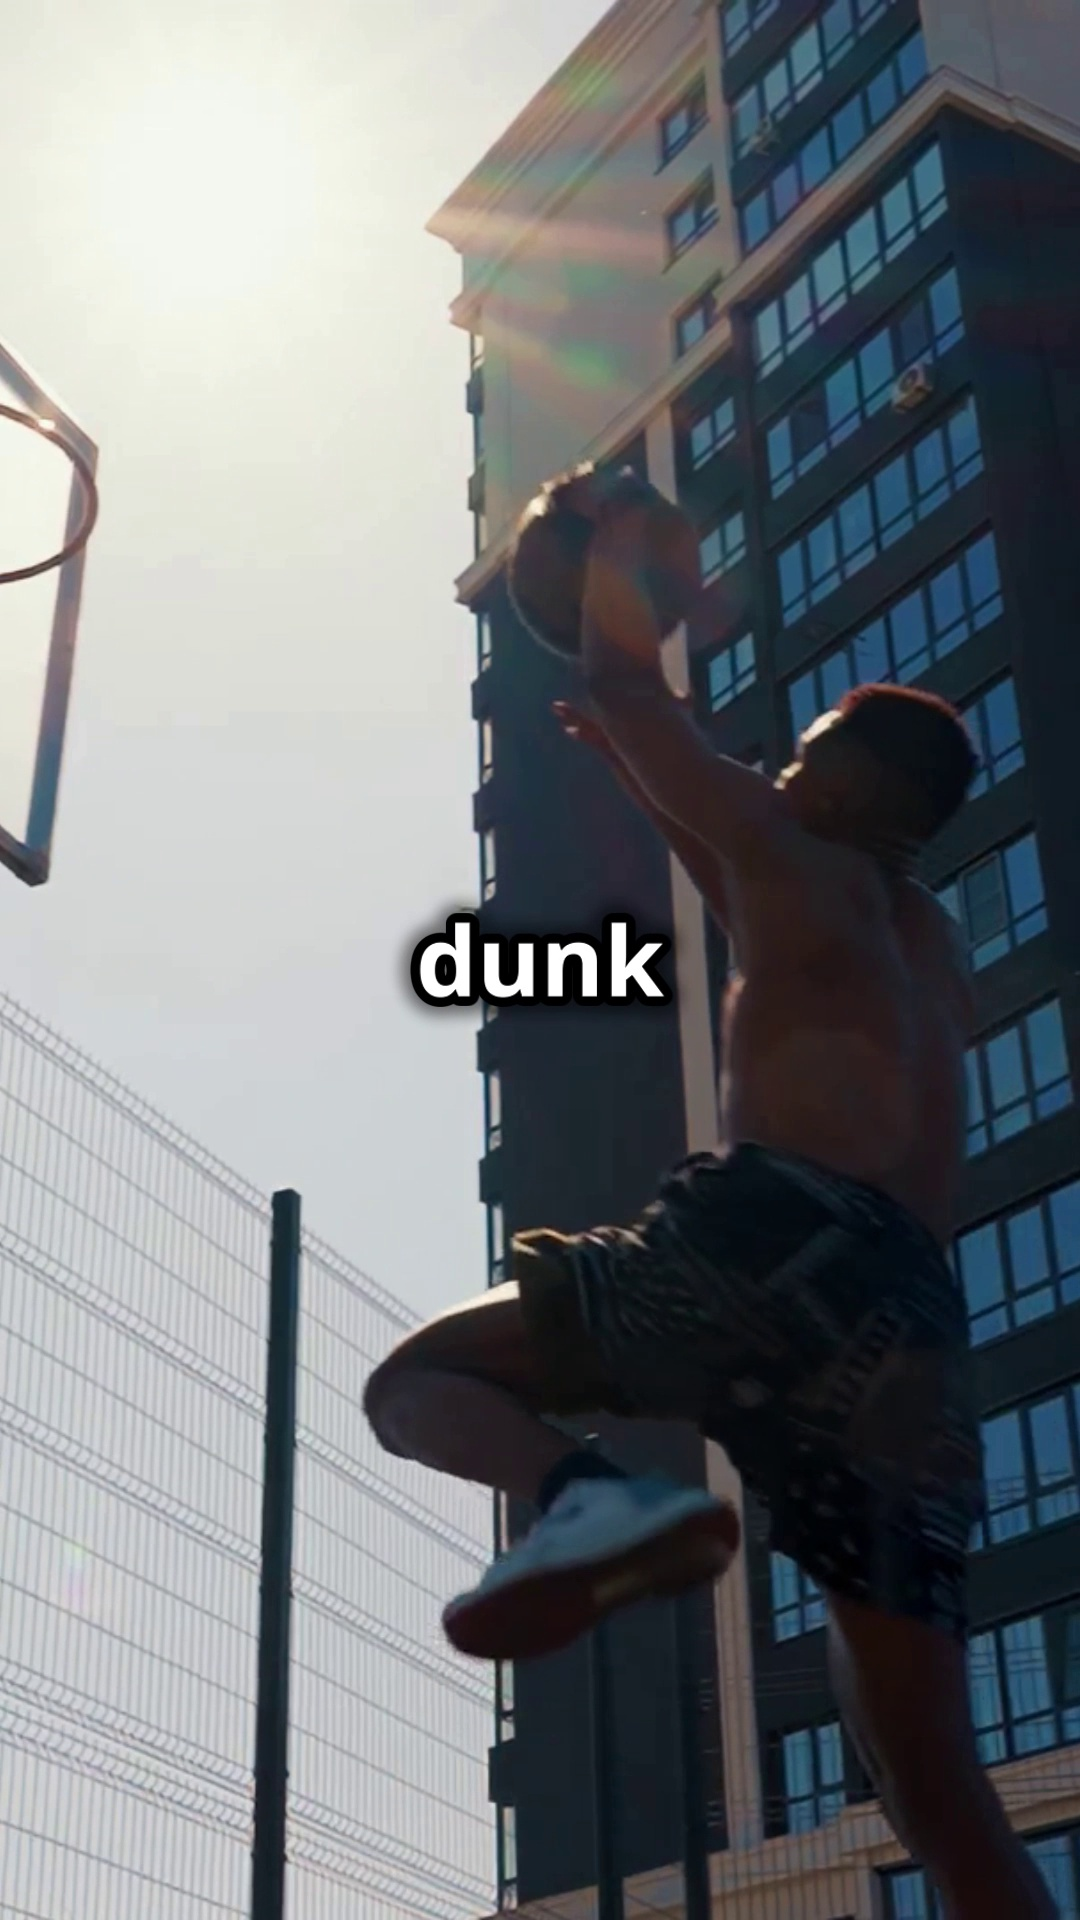

In [ ]:
# process frame
file_name_root = file_name.split('.')[0]
frame="frame_"+str(frame)+".jpg"
print(frame)
directory = "Chapter10/frames/"+file_name_root
print(directory)
download(directory,frame)
display_frame(frame)

# RAG

In [ ]:
prompt = text

response_content = get_openai_response(prompt)
print(response_content)

1. Cognitive Dissonances:
   - The comment is mostly consistent, but there is a slight redundancy in describing the action as a "dunk" when it is already stated that the word "dunk" is superimposed on the image. Additionally, the mention of "clear skies" and "modern building" could be more seamlessly integrated into the description of the setting.

2. Rewritten Comment:
   In this dynamic image, a basketball player is captured mid-air, executing an impressive dunk. With one arm stretched towards the hoop and a basketball firmly in hand, the athlete is poised to deliver a powerful slam. The word "dunk" is prominently displayed on the image, emphasizing the action. The scene is set against a backdrop of clear skies and a sleek, modern building, indicating an outdoor urban basketball court. The player's athletic attire and specialized basketball shoes highlight their readiness and skill in the sport, embodying the energy and excitement of a classic basketball moment.

3. Label: Basketball

# Evaluator

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [37]:
from google.colab import userdata
# userdata.get('HF_TOKEN')

In [ ]:
!pip install sentence-transformers==3.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity_with_embeddings(text1, text2):
    embeddings1 = model.encode(text1)
    embeddings2 = model.encode(text2)
    similarity = cosine_similarity([embeddings1], [embeddings2])
    return similarity[0][0]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import spacy

def spacy_similarity(text1, text2):
    # Load the medium-sized English model
    nlp = spacy.load('en_core_web_md')

    # Process the texts
    doc1 = nlp(text1)
    doc2 = nlp(text2)

    # Calculate semantic similarity
    similarity_score = doc1.similarity(doc2)

    return similarity_score

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    similarity = cosine_similarity(tfidf[0:1], tfidf[1:2])
    return similarity[0][0]


In [ ]:
text1 = " In this image, a basketball player is captured mid-air, executing a powerful dunk. With one arm extended towards the hoop and the basketball firmly in hand, the athlete is poised to slam the ball through the net. The player's athletic wear and basketball shoes highlight their readiness for the sport. The urban outdoor court setting adds to the dynamic and energetic atmosphere of the scene."
text2 = "In this image, a basketball player is shown making a super cool dunk in mid-air."
similarity_score1 = calculate_cosine_similarity(text1, text2)
print(f"Cosine Similarity Score with sklearn: {similarity_score1:.3f}")

similarity_score2 = spacy_similarity(text1, text2)
print(f"Semantic Similarity Score with spaCy: {similarity_score2:.3f}")

similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")

similarity_score4 = 0.75
print(f"Cosine Similarity Score with human feedback: {similarity_score4:.3f}")

Cosine Similarity Score with sklearn: 0.201
Semantic Similarity Score with spaCy: 0.862
Cosine Similarity Score with sentence transformer: 0.797
Cosine Similarity Score with human feedback: 0.750


In [ ]:
def extract_rewritten_comment(response):
    """
    Extracts the rewritten comment from GPT-4o response.
    """
    lines = response.split('\n')
    rewritten_comment = []
    rewrite_started = False
    for line in lines:
        if "Rewritten Comment:" in line:
            rewrite_started = True
            continue
        if rewrite_started:
            if line.strip() == "":
                break
            rewritten_comment.append(line.strip())
    return " ".join(rewritten_comment)